In [60]:
%reset

In [61]:
#Imports
import numpy as np
import cobra as cb
import pandas as pd
import matplotlib.pyplot as plt
from cobra import Model, Reaction, Metabolite

In [62]:
import copy
#Load the base genome model

EC_model_PTB_BUK = cb.io.load_matlab_model("iML1515.mat")

#Second model for CoA-transferase pathway
EC_model_CoA = copy.deepcopy(EC_model_PTB_BUK)
EC_model_PTB_BUK

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


Name,iML1515
Memory address,185b53883b0
Number of metabolites,1877
Number of reactions,2712
Number of genes,1516
Number of groups,40
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"c, e, p"


In [38]:
#add reaction function

def add_rxn(model, rxn_id, name, stoich, reversible=True):
    if rxn_id in model.reactions:
        print(f"{rxn_id} already exists")
        return
    
    rxn = Reaction(rxn_id)
    rxn.name = name
    rxn.lower_bound = -1000 if reversible else 0
    rxn.upper_bound = 1000

    mets = {}
    for met_id, coeff in stoich.items():
        if met_id not in model.metabolites:
            print(f"⚠ Creating missing metabolite: {met_id}")
            model.add_metabolites([Metabolite(met_id)])
        mets[model.metabolites.get_by_id(met_id)] = coeff
    
    rxn.add_metabolites(mets)
    model.add_reactions([rxn])
    print(f"Added {rxn_id}: {name}")



In [ ]:
#Add the butyrate synthesis pathway via PTB/BUK
# 1. Acetyl-CoA → Acetoacetyl-CoA  (AtoB)

add_rxn(EC_model_PTB_BUK,"BUT1_THIOLASE","Acetyl-CoA acetyltransferase",
    {"accoa_c": -2,
    "aacoa_c": 1,
    "coa_c": 1}
)


# 2. Acetoacetyl-CoA → 3-Hydroxybutyryl-CoA (Hbd)

add_rxn(EC_model_PTB_BUK,"BUT2_HBD","3-hydroxybutyryl-CoA dehydrogenase",
    {"aacoa_c": -1,
    "nadh_c": -1,
    "h_c": -1,
    "3hbcoa_c": 1,
    "nad_c": 1},
    reversible=False
)

# 3. 3-HB-CoA → Crotonyl-CoA (Crt)

add_rxn(EC_model_PTB_BUK,"BUT3_CRT","Crotonase",
    {"3hbcoa_c": -1,
    "crocoa_c": 1,
    "h2o_c": 1}   
)

# 4. Crotonyl-CoA → Butyryl-CoA (Bcd–EtfAB)

add_rxn(EC_model_PTB_BUK,"BUT4_BCD","Butyryl-CoA dehydrogenase",
    {"crocoa_c": -1,
    "nadh_c": -1,
    "h_c": -1,
    "btcoa_c": 1,
    "nad_c": 1},
    reversible=False
)

# 5. phosphotransbutyrylase /BUK  (Clostridial)

# PTB
add_rxn(EC_model_PTB_BUK,"BUT5A_PTB","Phosphate butyryltransferase",
    {"btcoa_c": -1,
    "pi_c": -1,
    "btp_c": 1,
    "coa_c": 1}
)

# BUK
add_rxn(EC_model_PTB_BUK,"BUT5B_BUK","Butyrate kinase",
    {"btp_c": -1,
    "adp_c": -1,
    "but_c": 1,
    "atp_c": 1},
    reversible=False
)


# 5B. CoA-transferase (AtoDA)

add_rxn(EC_model_PTB_BUK,"BUT5C_ATODA","Butyryl-CoA:acetate CoA-transferase",
    {"btcoa_c": -1,
    "ac_c": -1,
    "but_c": 1,
     "accoa_c": 1}
)

# 6. Reaction for butyrate synthesis! (finally)

add_rxn(EC_model_PTB_BUK,"BUTYRATE_EXPORT","Butyrate export",
    {"but_c": -1,
    "but_e": 1},
    reversible=False
)

Added BUT1_THIOLASE: Acetyl-CoA acetyltransferase
Added BUT2_HBD: 3-hydroxybutyryl-CoA dehydrogenase
⚠ Creating missing metabolite: crocoa_c
Added BUT3_CRT: Crotonase
Added BUT4_BCD: Butyryl-CoA dehydrogenase
⚠ Creating missing metabolite: btp_c
Added BUT5A_PTB: Phosphate butyryltransferase
Added BUT5B_BUK: Butyrate kinase
Added BUT5C_ATODA: Butyryl-CoA:acetate CoA-transferase
Added BUTYRATE_EXPORT: Butyrate export


In [40]:
#add reactions for the CoA-transferase pathway
# 1. Acetyl-CoA → Acetoacetyl-CoA  (AtoB)

add_rxn(EC_model_CoA,"BUT1_THIOLASE","Acetyl-CoA acetyltransferase",
    {"accoa_c": -2,
    "aacoa_c": 1,
    "coa_c": 1}
)


# 2. Acetoacetyl-CoA → 3-Hydroxybutyryl-CoA (Hbd)

add_rxn(EC_model_CoA,"BUT2_HBD","3-hydroxybutyryl-CoA dehydrogenase",
    {"aacoa_c": -1,
    "nadh_c": -1,
    "h_c": -1,
    "3hbcoa_c": 1,
    "nad_c": 1},
    reversible=False
)

# 3. 3-HB-CoA → Crotonyl-CoA (Crt)

add_rxn(EC_model_CoA,"BUT3_CRT","Crotonase",
    {"3hbcoa_c": -1,
    "crocoa_c": 1,
    "h2o_c": 1}   
)

# 4. Crotonyl-CoA → Butyryl-CoA (Bcd–EtfAB)

add_rxn(EC_model_CoA,"BUT4_BCD","Butyryl-CoA dehydrogenase",
    {"crocoa_c": -1,
    "nadh_c": -1,
    "h_c": -1,
    "btcoa_c": 1,
    "nad_c": 1},
    reversible=False
)

# Step 5 alternative (ATP-free CoA-transferase)
add_rxn(EC_model_CoA,"BUT_COAT","Butyryl-CoA:acetate CoA-transferase",
    {"btcoa_c": -1,
     "ac_c": -1,
     "but_c": 1,
     "accoa_c": 1},
    reversible=False
)

# Step 6 export
add_rxn(EC_model_CoA,"BUTYRATE_EXPORT","Butyrate export",
    {"but_c": -1,
     "but_e": 1},
    reversible=False
)


BUT1_THIOLASE already exists
BUT2_HBD already exists
BUT3_CRT already exists
BUT4_BCD already exists
Added BUT_COAT: Butyryl-CoA:acetate CoA-transferase
BUTYRATE_EXPORT already exists


In [50]:
#set ATP maintenance
EC_model_PTB_BUK.reactions.ATPM.lower_bound = 10
EC_model_CoA.reactions.ATPM.lower_bound = 10

In [ ]:
#create medium simulating human gut environment
gut_medium = {
    'EX_glc__D_e': 10.0,   # glucose 
    'EX_nh4_e': 1000.0,    # ammonium
    'EX_pi_e': 1000.0,     # phosphate
    'EX_so4_e': 1000.0,    # sulfate
    'EX_k_e': 1000.0,       # potassium
    'EX_na1_e': 1000.0,     # sodium
    'EX_h2o_e': 1000.0,     # water
    'EX_co2_e': 1000.0,    # carbon dioxide
    'EX_h_e': 1000.0,     # protons
    'EX_ac_e': 0.0,        # acetate needed for CoA-transferase part (synthetic)
    'EX_but_e': 0.0,       # butyrate not supplied in beginning, starting at zero
    'EX_o2_e': 0.0         # anaerobic
}

gut_medium_updated = {
    'EX_pi_e': 1000.0,  # phosphate
    'EX_co2_e': 1000.0, # carbon dioxide
    'EX_fe3_e': 1000.0, # ferric ion
    'EX_h_e': 1000.0,   # protons
    'EX_mn2_e': 1000.0, # manganous ion
    'EX_fe2_e': 1000.0, # ferrous ion
    'EX_glc__D_e': 10.0,    # glucose
    'EX_zn2_e': 1000.0, # zinc ion
    'EX_mg2_e': 1000.0, # magnesium ion
    'EX_ca2_e': 1000.0, # calcium ion
    'EX_ni2_e': 1000.0, # nickel ion
    'EX_cu2_e': 1000.0, # cupric ion
    'EX_cobalt2_e': 1000.0, # cobalt ion
    'EX_h2o_e': 1000.0, # water
    'EX_mobd_e': 1000.0,    # molybdate
    'EX_so4_e': 1000.0, # sulfate
    'EX_nh4_e': 1000.0,   # ammonium
    'EX_k_e': 1000.0,   # potassium
    'EX_cl_e': 1000.0,  # chloride
    'EX_o2_e': 0.0,  # anaerobic
    'EX_ac_e': 10.0        # acetate needed for CoA-transferase part (synthetic)
}

In [ ]:
#add the medium to PTB/BUK model
for ex in EC_model_PTB_BUK.exchanges:
    ex.lower_bound = 0   # block uptake
    ex.upper_bound = 1000

for ex_id, value in gut_medium_updated.items():
    if ex_id in EC_model_PTB_BUK.reactions:
        EC_model_PTB_BUK.reactions.get_by_id(ex_id).lower_bound = -float(value)   # uptake = negative
    else:
        print("Missing exchange:", ex_id)

if "EX_o2_e" in EC_model_PTB_BUK.reactions:
    EC_model_PTB_BUK.reactions.EX_o2_e.lower_bound = 0

sol = EC_model_PTB_BUK.optimize()
print(EC_model_PTB_BUK.summary())

#add the medium to CoA-transferase model
for ex in EC_model_CoA.exchanges:
    ex.lower_bound = 0   # block uptake
    ex.upper_bound = 1000

for ex_id, value in gut_medium_updated.items():
    if ex_id in EC_model_CoA.reactions:
        EC_model_CoA.reactions.get_by_id(ex_id).lower_bound = -float(value)   # uptake = negative
    else:
        print("Missing exchange:", ex_id)
    
if "EX_o2_e" in EC_model_CoA.reactions:
    EC_model_CoA.reactions.EX_o2_e.lower_bound = 0

sol = EC_model_CoA.optimize()
print(EC_model_CoA.summary())


Objective
1.0 BUTYRATE_EXPORT = 59.9999999999977

Uptake
------
Metabolite    Reaction Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e   10         6 100.00%

Secretion
---------
Metabolite Reaction Flux  C-Number C-Flux
     but_e EX_but_e  -10         4 66.67%
     for_e EX_for_e  -20         1 33.33%
       h_e   EX_h_e  -30         0  0.00%



In [53]:
#add medium to CoA-transferase model
with EC_model_CoA as model:
    for ex in model.exchanges:
        ex.lower_bound = 0   # block uptake
        ex.upper_bound = 1000

    for ex_id, value in gut_medium_updated.items():
        if ex_id in model.reactions:
            model.reactions.get_by_id(ex_id).lower_bound = -float(value)   # uptake = negative
        else:
            print("Missing exchange:", ex_id)

    if "EX_o2_e" in model.reactions:
        model.reactions.EX_o2_e.lower_bound = 0

    sol = model.optimize()
    print(model.summary())


Objective
1.0 BUTYRATE_EXPORT = 60.0000000000003

Uptake
------
Metabolite    Reaction Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e   10         6 100.00%

Secretion
---------
Metabolite Reaction Flux  C-Number C-Flux
     but_e EX_but_e  -10         4 66.67%
     for_e EX_for_e  -20         1 33.33%
       h_e   EX_h_e  -30         0  0.00%



Computing production envelope...


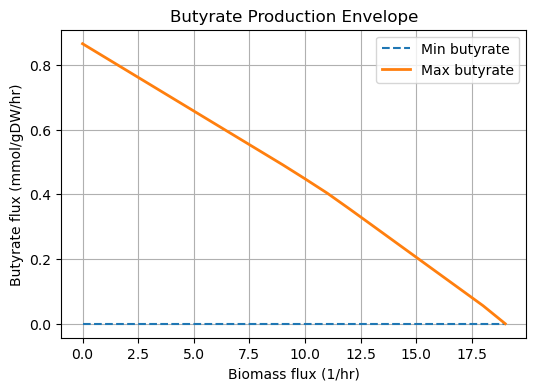


ATP / NADH balance at optimal biomass:
Net ATP (positive = net production): -0.0000
Net NADH (positive = net production): 0.0000
ATPM flux = 10.0000

Done.


In [54]:
from cobra.flux_analysis import production_envelope


# --------------------------------------------------------
# 1) FIND BIOMASS REACTION
# --------------------------------------------------------
def find_biomass_rxn(m):
    for r in m.reactions:
        if "biomass" in r.id.lower() or "biomass" in r.name.lower():
            return r
    raise RuntimeError("Biomass reaction not found — set model.objective manually.")

biomass_rxn = find_biomass_rxn(model)
model.objective = biomass_rxn


# --------------------------------------------------------
# 2) PRODUCTION ENVELOPE (biomass vs butyrate)
# --------------------------------------------------------
print("Computing production envelope...")

env = production_envelope(
    model,
    reactions=["EX_but_e"],      # use correct keyword for your COBRA version
    objective=biomass_rxn,       # pass reaction object
    points=20
)

# always convert to DataFrame
env = pd.DataFrame(env)


# --------------------------------------------------------
# 3) PLOT ENVELOPE
# --------------------------------------------------------
biomass_flux = env.index.values  # or np.linspace(0, max_growth, points) depending on your version

plt.figure(figsize=(6,4))
plt.plot(biomass_flux, env["flux_minimum"], "--", label="Min butyrate")
plt.plot(biomass_flux, env["flux_maximum"], label="Max butyrate", linewidth=2)

plt.xlabel("Biomass flux (1/hr)")
plt.ylabel("Butyrate flux (mmol/gDW/hr)")
plt.title("Butyrate Production Envelope")
plt.grid(True)
plt.legend()
plt.show()


# --------------------------------------------------------
# 4) ATP / NADH BALANCE
# --------------------------------------------------------
def net_cofactor_flux(solution, met_id):
    """Compute net (stoich * flux) for a metabolite in a FluxSolution."""
    total = 0.0
    for rxn_id, flux in solution.fluxes.items():
        if abs(flux) < 1e-9:
            continue
        rxn = model.reactions.get_by_id(rxn_id)
        for met, coeff in rxn.metabolites.items():
            if met.id == met_id:
                total += coeff * flux
    return total


print("\nATP / NADH balance at optimal biomass:")

model.objective = biomass_rxn
sol_now = model.optimize()

net_atp = net_cofactor_flux(sol_now, "atp_c")
net_nadh = net_cofactor_flux(sol_now, "nadh_c")

print(f"Net ATP (positive = net production): {net_atp:.4f}")
print(f"Net NADH (positive = net production): {net_nadh:.4f}")

for rid in ["ATPM", "ATPM_maintenance", "ATPS4r"]:
    if rid in model.reactions:
        print(f"{rid} flux = {sol_now.fluxes[rid]:.4f}")

print("\nDone.")


In [55]:
#max butyrate flux function
from cobra import Model, Reaction

def max_butyrate_flux(model):
    model.objective = "BUTYRATE_EXPORT"
    sol = model.optimize()
    return sol.objective_value

max_flux_eng = max_butyrate_flux(EC_model_PTB_BUK)   # PTB/BUK pathway
max_flux_coat = max_butyrate_flux(EC_model_CoA) # CoA-transferase pathway

print(f"Max butyrate flux (PTB/BUK) = {max_flux_eng:.4f}")
print(f"Max butyrate flux (CoA-transferase) = {max_flux_coat:.4f}")

Max butyrate flux (PTB/BUK) = 900.0000
Max butyrate flux (CoA-transferase) = 900.0000


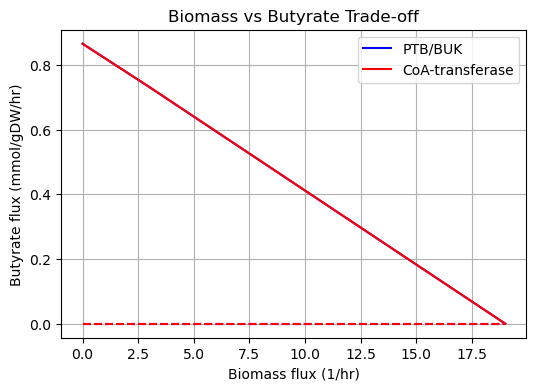

In [56]:
def plot_tradeoff(model, biomass_rxn, color, label):
    env = production_envelope(model,
                              reactions=["BUTYRATE_EXPORT"],
                              objective=biomass_rxn,
                              points=20)
    # In older COBRApy, x-axis is env.index
    x = env.index.values
    plt.plot(x, env["flux_minimum"], "--", color=color)
    plt.plot(x, env["flux_maximum"], color=color, label=label)

# Set biomass objective
biomass_rxn_PTB_BUK = find_biomass_rxn(EC_model_PTB_BUK)
biomass_rxn_CoA = find_biomass_rxn(EC_model_CoA)

plt.figure(figsize=(6,4))
plot_tradeoff(EC_model_PTB_BUK, biomass_rxn_PTB_BUK, "blue", "PTB/BUK")
plot_tradeoff(EC_model_CoA, biomass_rxn_CoA, "red", "CoA-transferase")

plt.xlabel("Biomass flux (1/hr)")
plt.ylabel("Butyrate flux (mmol/gDW/hr)")
plt.title("Biomass vs Butyrate Trade-off")
plt.grid(True)
plt.legend()
plt.show()

In [57]:
def net_atp_per_butyrate(model, butyrate_rxn="BUTYRATE_EXPORT"):
    model.objective = butyrate_rxn
    sol = model.optimize()
    
    # Net ATP production: sum over all reactions
    net_atp = 0.0
    for rxn_id, flux in sol.fluxes.items():
        rxn = model.reactions.get_by_id(rxn_id)
        for met, coeff in rxn.metabolites.items():
            if met.id == "atp_c":
                net_atp += coeff * flux
    # Divide by butyrate flux
    if sol.fluxes[butyrate_rxn] == 0:
        return 0
    return net_atp / sol.fluxes[butyrate_rxn]

atp_per_but_eng = net_atp_per_butyrate(EC_model_PTB_BUK)
atp_per_but_coat = net_atp_per_butyrate(EC_model_CoA)

print(f"ATP per butyrate (PTB/BUK) = {atp_per_but_eng:.4f}")
print(f"ATP per butyrate (CoA-transferase) = {atp_per_but_coat:.4f}")


ATP per butyrate (PTB/BUK) = -0.0000
ATP per butyrate (CoA-transferase) = -0.0000
